# Поддержание активности покупателей интернет-магазина

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений, полученных на основе анализа данных и бизнес-моделирования. 

**Цель:**
- разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Руководитель отдела сформировал подход к решению вопроса:
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

**Задачи**:
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

Данные для работы находятся в нескольких таблицах:
- `market_file.csv`: таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. 
- `market_money.csv`: таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `market_time.csv`: таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `money.csv`:  таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


Исследование пройдёт в несколько этапов:
1. Обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных
4. Обучение моделей (линейной и логистической регрессии).
5. Интерпретация результатов и выводы.


## 1. Обзор данных

In [1]:
! pip install shap -q
! pip install phik -q

In [2]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error , r2_score, recall_score, accuracy_score, precision_score, confusion_matrix, 
roc_auc_score, f1_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import shap
import phik
from phik.report import plot_correlation_matrix
shap.initjs()
r_s = 42

In [3]:
#открываем файлы и записываем в переменные - столбцы разделены точкой с запятой, а числовые данные записаны с запятой
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')
except:
    market_file = pd.read_csv('market_file.csv')
    market_money = pd.read_csv('market_money.csv')
    market_time = pd.read_csv('market_time.csv')
    money = pd.read_csv('money.csv', sep = ';', decimal = ',')

### 1.1 Таблица `market_file.csv`

In [4]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Таблица `market_file.csv` представляет собой 1300 записи о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Пропусков в таблице нет.

В таблице 13 столбцов:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Есть опечатки в колонке Тип сервиса.

### 1.2 Таблица `market_money.csv`

с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. В качестве периодов представлены текущий и два прошедших месяца.

In [7]:
market_money.sample(5)

,id,Период,Выручка
1199,215747,текущий_месяц,4089.3
1905,215983,текущий_месяц,5384.5
1059,215701,препредыдущий_месяц,4444.0
2780,216274,текущий_месяц,4880.8
717,215587,препредыдущий_месяц,4912.0


In [8]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [10]:
market_money['Период'].value_counts()

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: Период, dtype: int64

В таблице 3900 записей и 3 столбца: 
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

Пропусков нет.

### 1.3 Таблица `market_time.csv`

с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [11]:
market_time.sample(5)

,id,Период,минут
1004,215850,текущий_месяц,16
1153,215924,предыдцщий_месяц,13
2149,216422,текущий_месяц,17
1618,216157,предыдцщий_месяц,17
36,215366,текущий_месяц,14


In [12]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [14]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

В таблице 2600 записей и 3 столбца: 
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах

Есть опечатка в колонке Период.

### 1.4 Таблица `money.csv`

с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [15]:
money.sample(5)

,id,Прибыль
654,216002,4.28
70,215418,4.98
469,215817,2.43
959,216307,3.16
211,215559,3.58


In [16]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [17]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [18]:
# проверим одинково ли в таблицах количество уникальных клиентов
(money.id.nunique()+market_time.id.nunique()+ market_money.id.nunique()+market_file.id.nunique())/1300

4.0

### 1.5 Вывод
 - Данные в четырех таблицах соответствуют описанию задачи. В каждой таблице 1300 уникальных клиентов.
 - Ни в одной таблице нет пропусков. 
 - Во всех таблицах нужно соотвествующе общепринятому стилю изменить названия столбцов.
 - Необходимо убрать опечатки в отмеченных колонках.
 - Типы данных соотвествуют описываемым признакам.

## 2.Предобработка данных
### 2.1 Переименование столбцов

Изменим имена столбцов в таблицах на названия в змеином регистре.

In [19]:
tables = [market_file, market_time, market_money, money]
for df in tables:
    df.columns = df.columns.str.lower()
    
    df.columns = df.columns.str.replace(' ','_')

In [20]:
for df in tables:
    print(df.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


### 2.2 Пропуски

При обзоре данных мы уже увидели, что пропусков нет.

### 2.3 Дубликаты

- проверим на неявные дубликаты и ошибки

In [21]:
l = []
for df in tables:
    data = pd.DataFrame()
    cat_cols = df.select_dtypes(exclude='number').columns
    for col in cat_cols:
        number = df[col].nunique()
        ar = df[col].unique()
        temp = pd.DataFrame({'column':[col],'nunique':[number],
                       'unique names':[ar]})
        data = data.append(temp)
    l.append(data)

In [22]:
l[0]

,column,nunique,unique names
0,покупательская_активность,2,"[Снизилась, Прежний уровень]"
0,тип_сервиса,3,"[премиум, стандартт, стандарт]"
0,разрешить_сообщать,2,"[да, нет]"
0,популярная_категория,6,"[Товары для детей, Домашний текстиль, Косметик..."


In [23]:
l[1]

,column,nunique,unique names
0,период,2,"[текущий_месяц, предыдцщий_месяц]"


In [24]:
l[2]

,column,nunique,unique names
0,период,3,"[препредыдущий_месяц, текущий_месяц, предыдущи..."


In [25]:
l[3]

""


In [26]:
market_file.популярная_категория.unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Опечатки есть в колонке тип_сервиса таблицы market_file и в колонке период таблицы market_time. 

И еще переведем все в нижний регистр.

In [27]:
for df in tables:
    for col in df.select_dtypes(exclude='number').columns:
        df[col] = df[col].str.lower()

In [28]:
market_file.покупательская_активность.unique()

array(['снизилась', 'прежний уровень'], dtype=object)

In [29]:
market_file.тип_сервиса = market_file.тип_сервиса.replace('стандартт', 'стандарт')
market_time.период = market_time.период.replace('предыдцщий_месяц', 'предыдущий_месяц')
market_file.тип_сервиса.unique()

array(['премиум', 'стандарт'], dtype=object)

In [30]:
market_time.период.unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

- явные дубликаты

In [31]:
for df in tables:
    print(df.duplicated().sum())

0
0
0
0


In [32]:
df = market_file
df = df.drop('id', axis=1)
df.duplicated().sum()

11

In [33]:
df[df.duplicated()].sample(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
550,снизилась,стандарт,да,5.5,4,703,0.14,мелкая бытовая техника и электроника,2,1,3,7
554,снизилась,стандарт,да,3.3,3,871,0.20,техника для красоты и здоровья,2,4,2,17
555,снизилась,стандарт,да,5.6,5,574,0.28,домашний текстиль,3,2,3,9
549,снизилась,стандарт,да,3.9,4,627,0.24,товары для детей,3,3,7,8
548,снизилась,стандарт,нет,4.3,4,460,0.16,техника для красоты и здоровья,2,1,3,6


### 2.4 Вывод
- Переименовали столбцы во всех таблицах: представили их змеиным регистром.
- Дополнительно проверили наличие пропусков. Их не обнаружено.
- Убрали неявные дубликаты из столбца `тип_сервиса` таблицы  market_file.
- Убрали опечатку в столбце `период` таблицы  market_time.
- Явных дубликатов не обнаружено.

## 3. Исследовательский анализ данных

Нас интересуют клиенты с покупательской активностью не менее трёх месяцев, то есть такие, которые что-либо покупали в этот период. Отберем их.

In [34]:
market_money[market_money['выручка']==0].id.unique()

array([215348, 215357, 215359])

In [35]:
market_money[~market_money['id'].isin(market_money[market_money['выручка']==0].id.unique())].id.nunique()

1297

In [36]:
market_money_active = market_money[~market_money['id'].isin(market_money[market_money['выручка']==0].id.unique())]
market_time_active = market_time[~market_time['id'].isin(market_money[market_money['выручка']==0].id.unique())]
money_active = money[~money['id'].isin(market_money[market_money['выручка']==0].id.unique())]
market_file_active = market_file[~market_file['id'].isin(market_money[market_money['выручка']==0].id.unique())]

In [37]:
market_file_active.shape[0]

1297

Всего три клиента из представленных были в какой-то из представленных периодов неактивны. Итого осталось 1297 клиентов, активных в течение трех месяцев. Сохранили данные об актвиных клиентах в датафрейме market_money_active.

### 3.1 Исследование количественных данных

Для количественных переменных построим гистограммы и ящики с усами.

Cоздадим две функции для визуализации количественных перменных.

In [38]:
def hist_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.histplot(data = data[col], ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel('Число клиентов')

In [39]:
def box_for_nums(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.boxplot(data = data[col].values, ax=ax)
        ax.set_title(col)
        ax.set_ylabel(col)

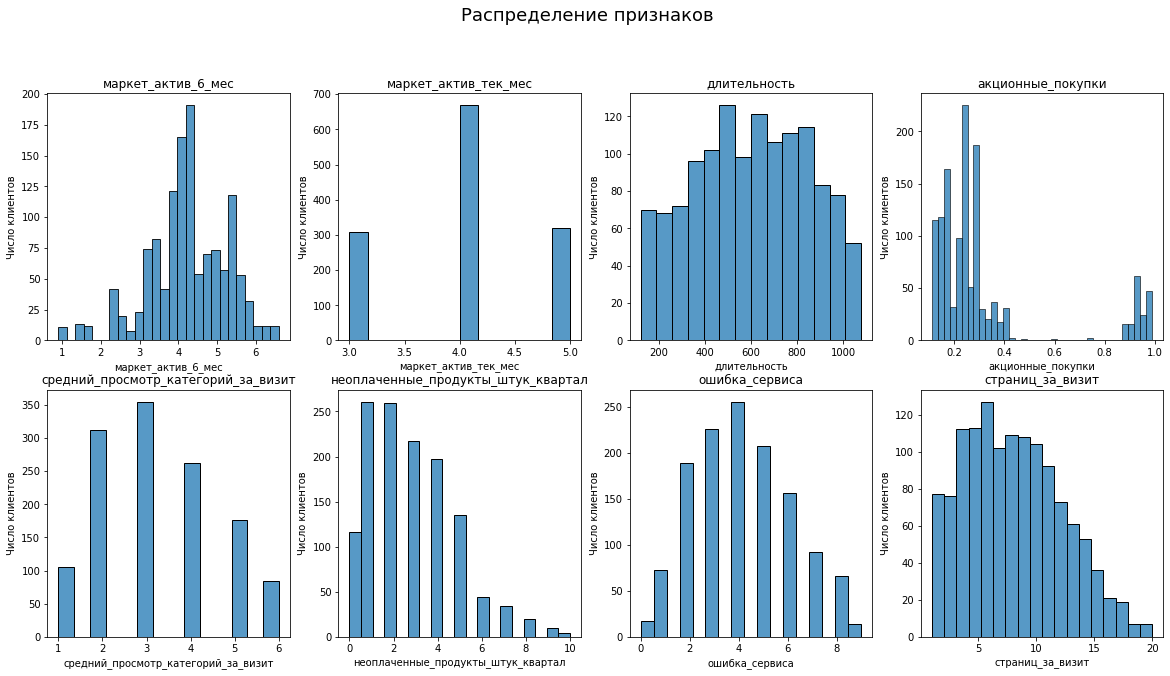

In [40]:
num_cols = market_file_active.select_dtypes(include='number').drop('id', axis=1).columns 
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Распределение признаков' , fontsize=18,  y=1)
hist_for_nums(market_file_active, num_cols)

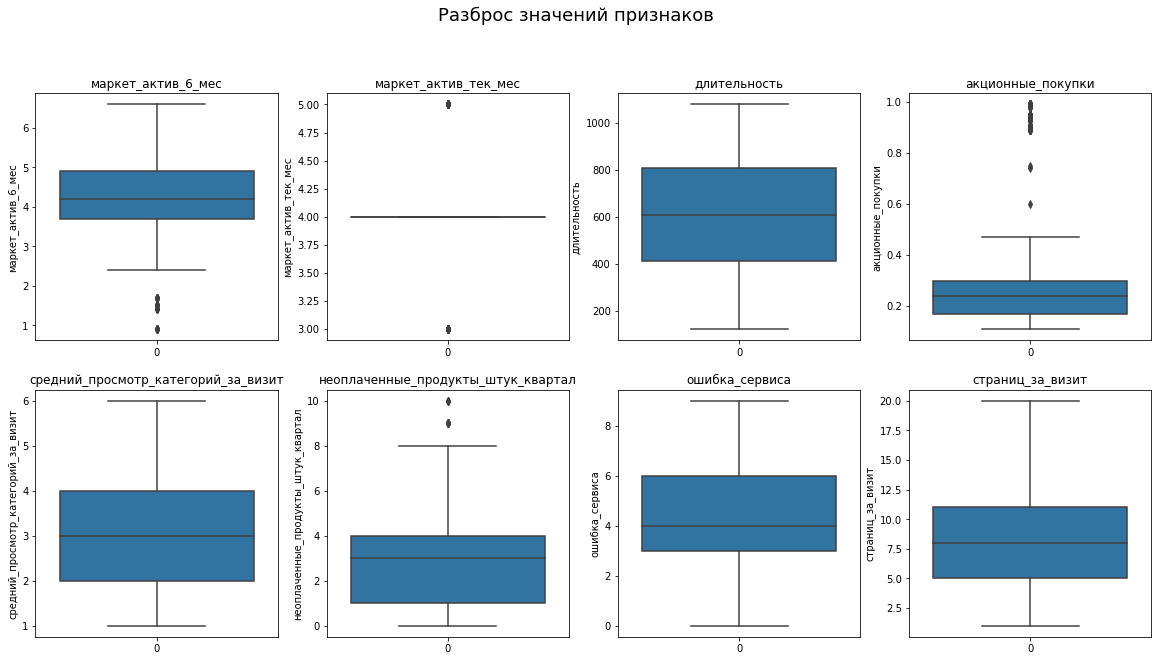

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle('Разброс значений признаков' , fontsize=18,  y = 1)
box_for_nums(market_file_active, num_cols)

In [42]:
money_active.sample()

,id,прибыль
1051,216399,1.57


Text(0, 0.5, 'Число клиентов')

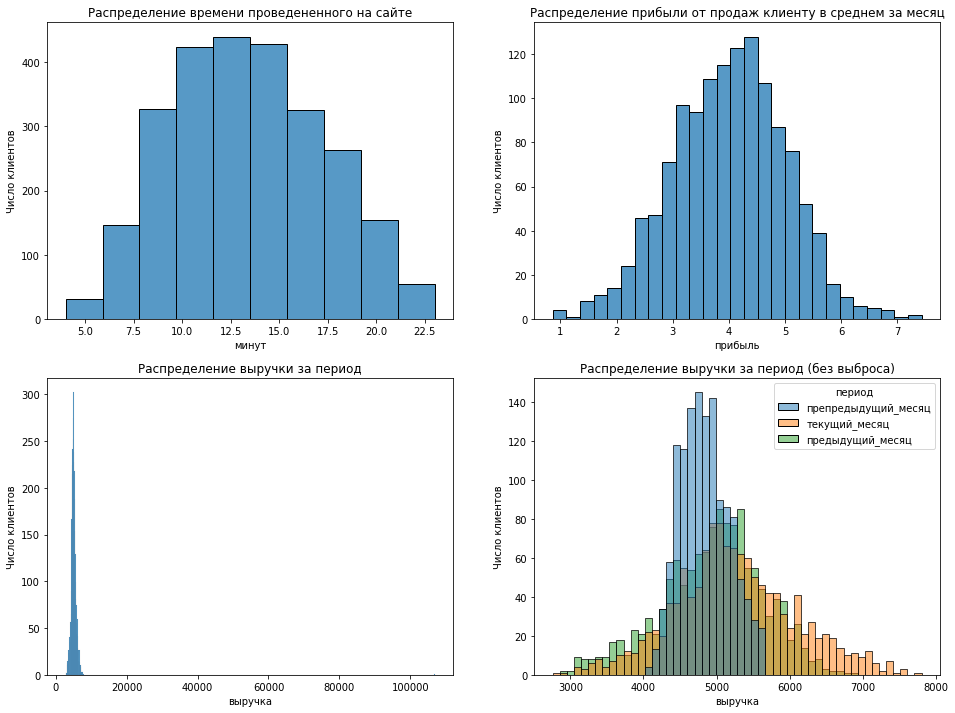

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
sns.histplot(x = market_time_active['минут'], ax=axs[0,0], bins=10)
axs[0,0].set_ylabel('Число клиентов')
axs[0,0].set_title('Распределение времени проведененного на сайте')
sns.histplot(data = market_money_active, x ='выручка', ax=axs[1,0])
axs[1,0].set_title('Распределение выручки за период')
axs[1,0].set_ylabel('Число клиентов')
sns.histplot(data = money_active, x='прибыль', ax=axs[0,1])
axs[0,1].set_title('Распределение прибыли от продаж клиенту в среднем за месяц')
axs[0,1].set_ylabel('Число клиентов')
sns.histplot(data = market_money_active.query('выручка < 100000'), x ='выручка',hue='период', ax=axs[1,1])
axs[1,1].set_title('Распределение выручки за период (без выброса)')
axs[1,1].set_ylabel('Число клиентов')

Text(0.5, 1.0, 'Разброс прибыли от продаж клиенту в среднем за месяц')

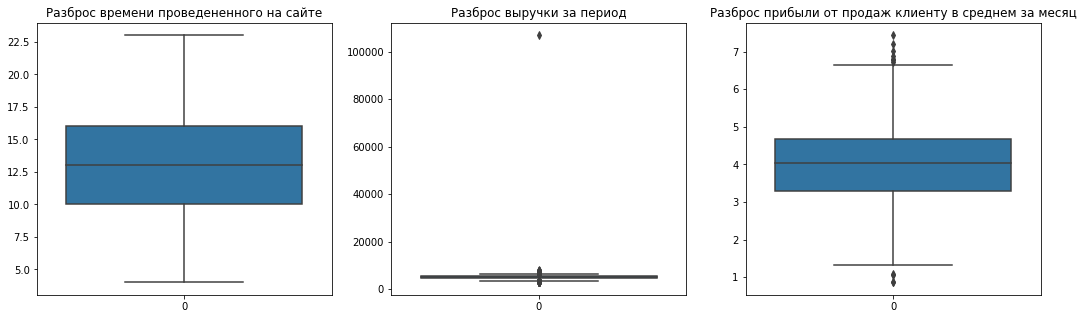

In [44]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 5))
sns.boxplot(data = market_time_active['минут'].values, ax=axs[0])
axs[0].set_title('Разброс времени проведененного на сайте')
sns.boxplot(data = market_money_active['выручка'].values, ax=axs[1])
axs[1].set_title('Разброс выручки за период')
sns.boxplot(data = money_active['прибыль'].values, ax=axs[2])
axs[2].set_title('Разброс прибыли от продаж клиенту в среднем за месяц')

Настраживает значение выручки за период для одного пользователя, которая достигает значений выше 100 тысяч. В принципе, это может быть разовая очень дорогая покупка.

In [45]:
market_money_active.query('выручка>100000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [46]:
market_file_active.query('id == 215380')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
32,215380,снизилась,премиум,нет,1.7,4,637,0.94,техника для красоты и здоровья,3,2,4,7


In [47]:
market_money_active.query('id == 215380')

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [48]:
money_active.query('id == 215380')

,id,прибыль
32,215380,3.88


In [49]:
market_time_active.query('id == 215380')

,id,период,минут
64,215380,предыдущий_месяц,12
65,215380,текущий_месяц,14


- В среднем, около 4 маркетинговых активностей в месяц приходится на пользователя.
- В датасете собраны пользователи, которые зарегистрировались на сайте не менее 121 дня назад. А в большинстве случаев с момента регистарции прошло около 600 дней.
- По использованию акций пользователи поделелилсь на группы - те, кто покупают преимущественно по акциям (более 80% покупок) и те, кто не так часто делает акционные покупки (примерно до 40% покупок). Вторая группа больше.
- В среднем, пользователь просматривает 2-4 категории товаров за визит.
- Большинство пользователей имели 1-4 неоплаченных товара в корзине.
- Среднее число сбоев на сайте во время посещения пользователем равно 4.
- В среднем, пользователь просматривает 5-10 страниц за визит и проводит на сайте 10-15 минут.
- Магазин получает в среднем за месяц около 4-5 т руб прибыли с пользователя. В текущем месяце пользователь 215380 аномально много потратил на покупки на общую сумму более 100 т.р. Других аномалий не найдено.

### 3.2 Исследование категориальных данных

Для категориальных сделаем круговые диаграммы.

In [50]:
def pie_for_cat(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        ax.pie(x = data.groupby(col)[col].count(), labels = data[col].unique(), autopct='%1.1f%%')
        ax.set_title(col)

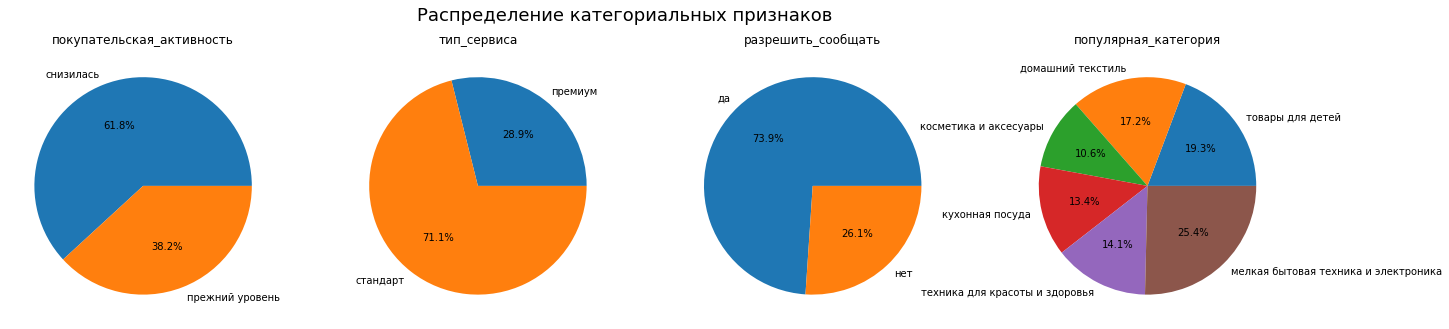

In [51]:
cat_cols = market_file_active.select_dtypes(exclude='number').columns
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(23, 5))
fig.suptitle('Распределение категориальных признаков' , fontsize=18,  y = 1)
pie_for_cat(market_file_active, cat_cols)


In [52]:
def count_for_cat(data, cols):
    for col, ax in zip(cols, axs.ravel()):
        sns.countplot(x=data[col], data=data, order=data[col].value_counts().index, ax=ax)
        ax.set_title(col)
        for i, v in enumerate(round(data[col].value_counts(normalize=True),2)):
            ax.text(i, v, str(v), ha='center')

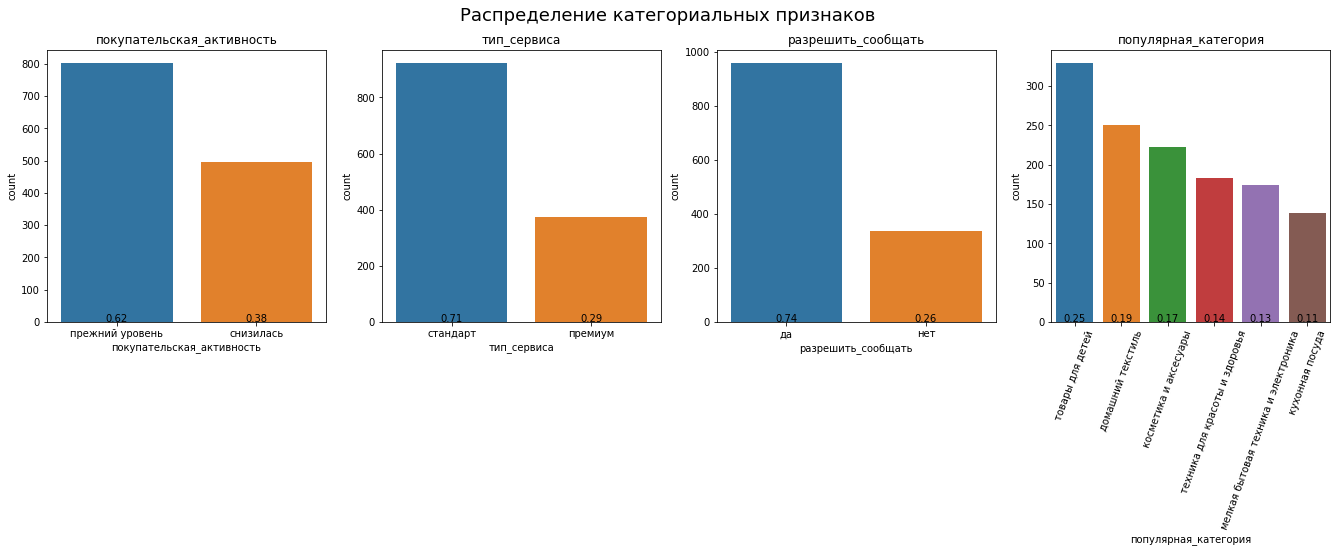

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(23, 5))
fig.suptitle('Распределение категориальных признаков' , fontsize=18,  y = 1)
count_for_cat(market_file_active, cat_cols)
axs[3].set_xticklabels(market_file_active['популярная_категория'].value_counts().index,rotation=70);

- у 60% пользователей снизилась активность на сайте.
- 30 % пользователей пользуются премиум-сервисом.
- более 70% пользователей получают дополнительные предложения о товаре.
- Интерес по шести категориям распределен практически равномерно. Однако из них наиболее популярная мелкая бытовая техника и электроника, а наименее - косметика и аксесуары.

### 3.3 Вывод
- Все признаки распределены реалистично. Для одного пользователя есть аномально большая сумма покупок в текущем месяце.
- В среднем, около 4 маркетинговых активностей в месяц приходится на пользователя.
- Пользователи поделелилсь на группы активных и не очень по использованию акций.
- В среднем, пользователь просматривает 5-10 страниц за визит и проводит на сайте 10-15 минут.
- Активность более 60% пользователей на сайте снизилась.
- Большинство пользуются стандартным сервисом и получают дополнительную информацию о предложениях товара.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Данные загружены, отлично.

Хорошо, что применяешь метод .head()/.sample() таким образом в память не будет загружен весь датасет, объем которого может быть огромным.

Методы .info, .describe, .value_counts(), .unique() как правило часто встречаются и обязательны к применению в задачах по исследованию данных, ведь с их помощью можно получить первые инсайты. 

Итак, мы провели предварительный анализ данных, проверили данные на наличие пропусков и затем обработали их (аргументированно заполнили / удалили / оставили как есть). Теперь можно приступать собственно к анализу данных и ответам на вопросы проекта.

У тебя крутой и мощный EDA. Детальнейшая обработка данных. С графиками. С рассуждениями. Молодец, всё классно в этом разделе.

</div>

## 4. Объединение таблиц

In [54]:
market_money_piv = pd.pivot(market_money, index = 'id', columns='период', values='выручка')
market_money_piv.columns = 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц'
market_money_piv.sample(5)

,выручка_пред_месяц,выручка_препред_месяц,выручка_тек_месяц
id,,,
215478,2960.0,4682.0,3078.3
216593,5150.5,5053.0,5365.0
216328,3495.0,4339.0,4356.9
216223,6024.0,5307.0,6775.4
215396,5876.0,4805.0,6830.2


In [55]:
market_time_piv = pd.pivot(market_time, index = 'id', columns='период', values='минут')
market_time_piv.columns = 'минут_пред_месяц', 'минут_тек_месяц'
market_time_piv.sample(5)

,минут_пред_месяц,минут_тек_месяц
id,,
216155,20,21
215868,17,16
216289,12,12
215825,17,15
216126,18,10


In [56]:
all_data = market_file.merge(market_money_piv, left_on=market_file.id, right_on =market_money_piv.index).drop('key_0', axis=1)\
.merge(market_time_piv, left_on=market_file.id, right_on =market_time_piv.index).drop('key_0', axis=1)
all_data.shape

(1300, 18)

In [57]:
market_file.shape

(1300, 13)

### Вывод
- Преобразовали таблицы market_time, market_money так, чтобы для каждого периода был отдельный столбец.
- Соединили таблицы market_file и преобразованные market_time и market_money в одно таблицу all_data.

## 5. Корреляционный анализ

Рассмотрим корреляцию в общем и по группам покупательской активности(прежний уровень, сниженный):

Text(0.5, 1.0, 'Матрица корреляций количественных признаков, метод Спирмена')

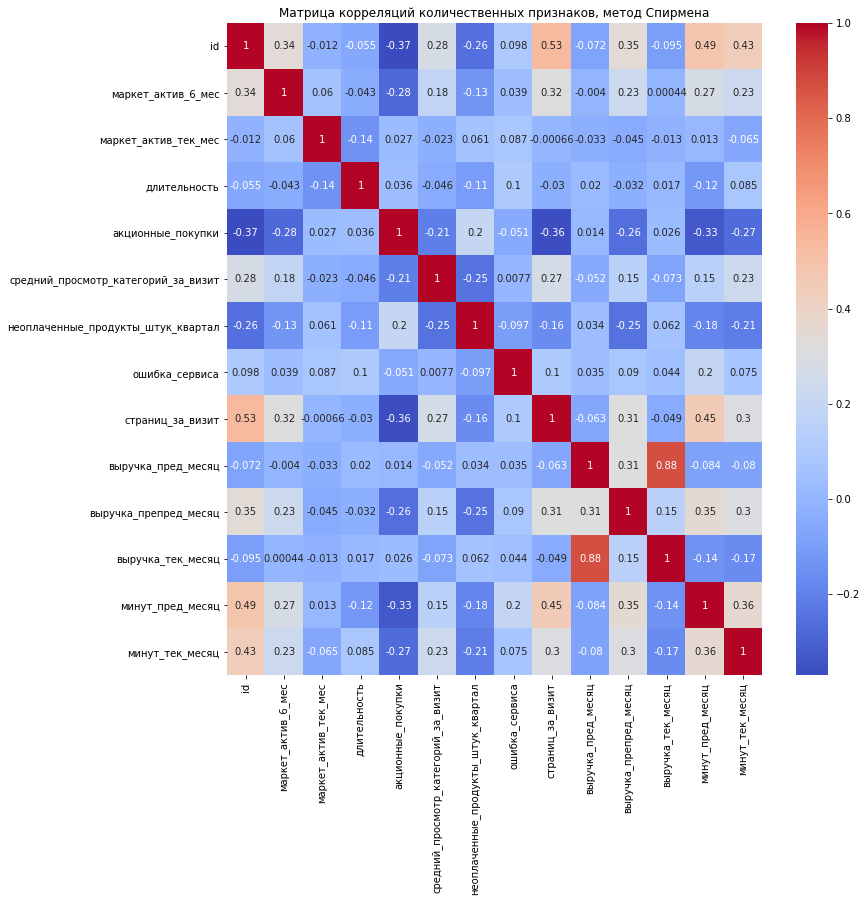

In [58]:
plt.figure(figsize = (12,12))
sns.heatmap(all_data.corr(method='spearman'),annot=True, cmap='coolwarm')
plt.title('Матрица корреляций количественных признаков, метод Спирмена')

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц', 'минут_пред_месяц', 'минут_тек_месяц']


Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column


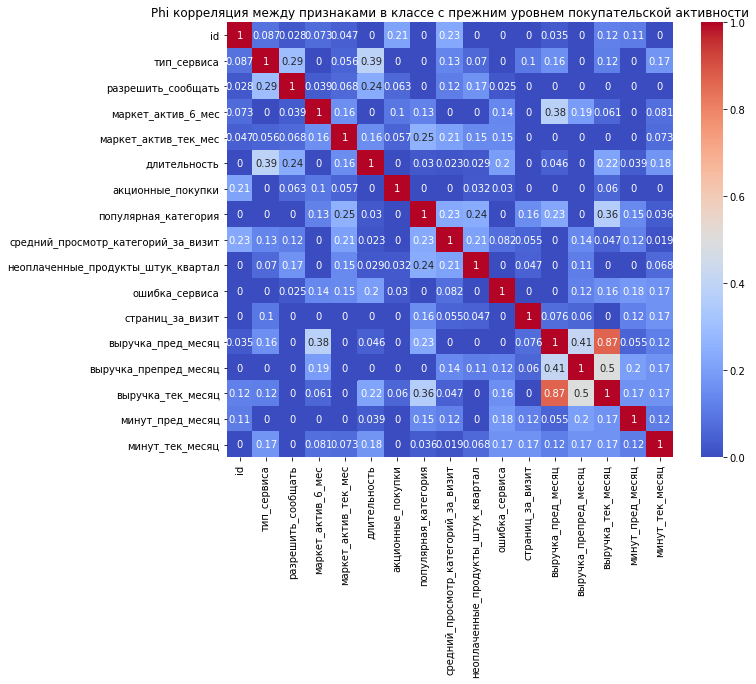

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_месяц', 'выручка_препред_месяц', 'выручка_тек_месяц', 'минут_пред_месяц', 'минут_тек_месяц']


Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column


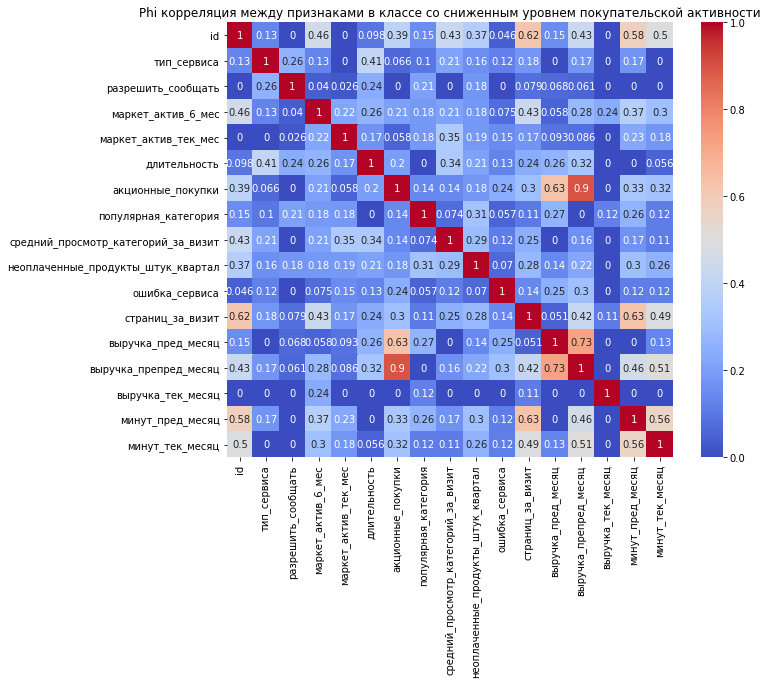

In [59]:
corr_matrix = all_data.query('покупательская_активность == "прежний уровень"').phik_matrix()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi корреляция между признаками в классе с прежним уровнем покупательской активности')
plt.show()

corr_matrix = all_data.query('покупательская_активность == "снизилась"').phik_matrix()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi корреляция между признаками в классе со сниженным уровнем покупательской активности')
plt.show()

- Согласно  корреляции Спирмена и корреляции Фи мультиколлинеарность присутствует между признаками "выручка_пред_месяц" и "выручка_тек_месяц", а также "выручка_препред_месяц" и "акционные_покупки". То есть акционные покупки можно сказать определяли выручку в препредыдущем месяце. 
- Есть умеренная положительная зависимость выручкой и количеством просмотренных страниц, выручкой и временем проведенным на сайте, временем на сайте и числом просмотренных страниц. 
- Также есть следующая зависимость - поведение пользователя от месяца к месяцу частично сохраняется. То есть, если он проводил n минут на сайте в прошлом месяце, то вероятно, в этом месяце тоже проведет на сайте примерно n минут.

### Вывод
- Мультиколлинеарность есть между признаками "выручка_пред_месяц" и "выручка_тек_месяц" , "выручка_препред_месяц" и "акционные_покупки" в классе сниженной активности. **Признаки "выручка_тек_месяц", "выручка_препред_месяц" не будем использовать при обучении модели.**
- Между некоторыми признаками есть линейная зависимость. Сообщение о дополнительных предложениях товара и выручка за текущий месяц и маркетинговая активность в текущем месяце самым слабым образом коррелируют с остальными признаками.

## 6. Подбор модели

Задача - создать модель классификации пользователей по покупательской активности на сайте (активность снизилась или прежний уровень) для того, чтобы понять через какие наиболее важные характеристики можно полиять и снова повысить активность пользователей.

Таргет - покупательская активность.

Входные признаки - все остальные представленные в объединенной таблице : выручка и время проведенное на сайте за посление месяцы, просмотренное число страниц, акционные покупки  и др.

Будем пробовать модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC(), подбирать для них гиперпараметры. 
Также нужно определиться с метрикой качества модели, чтобы выбрать лучший вариант. 

В ходе подбора лучшей модели воспользуемся пайпланами.

Для бинарных категориальных признаков применим OHE, для колонки популярная категория - OrdinalEncoder. Масштабировать количественные данные будем с помощью StandardScaler (в базовой модели).

### 6.1 Базовая модель

In [60]:
all_data = all_data.set_index('id')
all_data.sample()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_месяц,выручка_препред_месяц,выручка_тек_месяц,минут_пред_месяц,минут_тек_месяц
id,,,,,,,,,,,,,,,,,
215985,прежний уровень,стандарт,да,5.5,5,541,0.17,мелкая бытовая техника и электроника,4,1,6,5,5388.0,5223.0,5661.0,12,11


In [61]:
X = all_data.drop(['покупательская_активность', 'выручка_препред_месяц', 'выручка_тек_месяц'], axis=1)
y = all_data.покупательская_активность

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=r_s,
    stratify = y
    )

In [63]:
for x in [X_train, X_test, y_train, y_test]:
    print(x.shape)

(975, 14)
(325, 14)
(975,)
(325,)


Данные разбиты верно.

In [64]:
num_columns = X.select_dtypes(include='number').columns.to_list()
ohe_columns = X.select_dtypes(exclude='number').drop('популярная_категория', axis=1).columns.to_list()
ord_columns = ['популярная_категория']

In [65]:
ohe_columns

['тип_сервиса', 'разрешить_сообщать']

In [66]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [67]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=r_s))
    ]
)

In [68]:
# обучаем модель на тренировочной выборке
pipe_final.fit(X_train, y_train)

y_train_pred = pipe_final.predict(X_train)
print(f'Метрика ROC-AUC на тренировочной выборке: {roc_auc_score(y_train, pipe_final.predict_proba(X_train)[:, 1])}')
# применяем обученную модель на тестовой выборке
y_test_pred = pipe_final.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pipe_final.predict_proba(X_test)[:, 1])}')
print(f'Метрика accuracy на тестовой выборке: {accuracy_score(y_test, y_test_pred)}')
print(f'Метрика F1 на тестовой выборке: {f1_score(y_test, y_test_pred, pos_label="снизилась")}')

Метрика ROC-AUC на тренировочной выборке: 1.0
Метрика ROC-AUC на тестовой выборке: 0.8242256459637298
Метрика accuracy на тестовой выборке: 0.8246153846153846
Метрика F1 на тестовой выборке: 0.7816091954022989


Базовая модель уже неплохо прогнозирует классы. 
Так как мы хотим получить модель, которая наилучшим образом различает классы, будем пользоваться метрикой ROC-AUC.

### 6.2 Поиск лучшей модели 

In [69]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=r_s)],
        'models__max_depth': range(2, 8),
        'models__min_samples_split': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=r_s, probability=True)],
        'models__kernel': ['rbf', 'poly', 'sigmoid'],
        'models__degree': range(2, 6),
        #'models__C': np.arange(0, 10, 0.5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(penalty='l1',solver='saga', random_state=r_s)],
        'models__C': np.arange(0, 10, 0.5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [70]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=r_s,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать']),
                                                                              ('ord',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=nan),
                   

In [71]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика roc_auc для лучшей модели:
 0.8993445511627332

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['популярная_категория']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_ме

In [72]:
clf1 = randomized_search.best_estimator_

In [73]:
preds = clf1.predict(X_test)

In [74]:
roc_auc_score(y_test, clf1.predict_proba(X_test)[:,1])

0.9075991012678543

Значение roc_auc_score на тестовой выборке мало отличется от значения (на 1 %), что получено в RandomizedSearchCV подборе на тренировочной выборке. Значит модель хорошо описывает новые данные.

### 6.3 Вывод
Наилучшая модель для классификации пользователей по покупательской активности, выбранная в ходе RandomizedSearchCV - модель логистической регрессии с парметром регуляризации С=8.5, в качестве метода масштабирования выбран StandardScaler.

## 7. Анализ важности признаков SHAP

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 


In [75]:
clf1['preprocessor'].transformers_[0][1]

OneHotEncoder(drop='first', sparse=False)

Сделаем пару функций для препроцессинга.

In [76]:
def get_new_feature_names_from_ohe(num_columns, ord_columns, ohe):
    
    new_features = list(ohe.get_feature_names()) + ord_columns + num_columns
    
    return new_features

In [77]:
def transform_dataframe(df, num_columns, ord_columns, clf):
    
    ohe = clf['preprocessor'].transformers_[0][1]
    new_features = get_new_feature_names_from_ohe(num_columns, ord_columns, ohe)
    df_transformed = pd.DataFrame(clf["preprocessor"].transform(df), columns=new_features)
    df_transformed.index = df.index
    
    return df_transformed

In [78]:
classifier = clf1["models"]
X_train_processed = transform_dataframe(X_train, num_columns, ord_columns, clf1)
X_test_processed = transform_dataframe(X_test, num_columns, ord_columns, clf1)

In [79]:
explainer1 = shap.KernelExplainer(classifier.predict_proba, X_train_processed.sample(100))

In [80]:
shap_values = explainer1(X_test_processed[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

In [81]:
shap_values.shape

(10, 14, 2)

Посмотрим важность признаков:

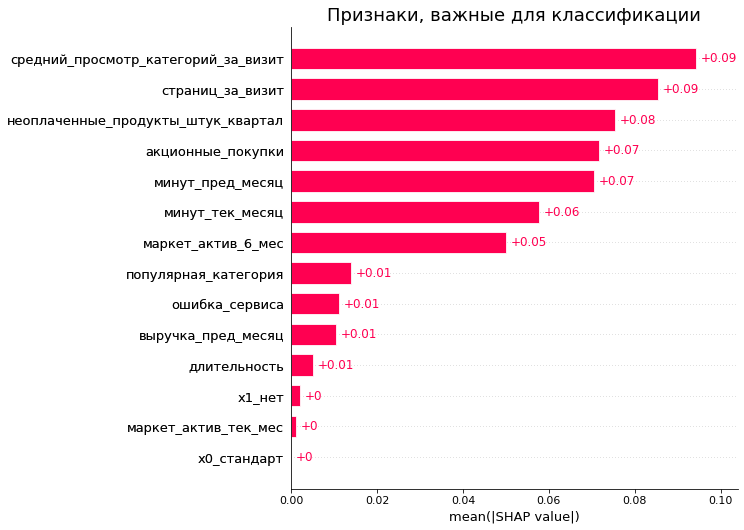

In [82]:
plt.title('Признаки, важные для классификации', fontsize=18)
shap.plots.bar(shap_values[:,:,1], max_display=16) 


Наиболее важными факторами по которым модель прогнозирует снижение активности пользователя являются число просмотренных категорий, страниц, количество проведенных на сайте минут, количество неоплаченных товаров в корзине, доля акционных покупок, количество маркетинговых активностей в месяц.

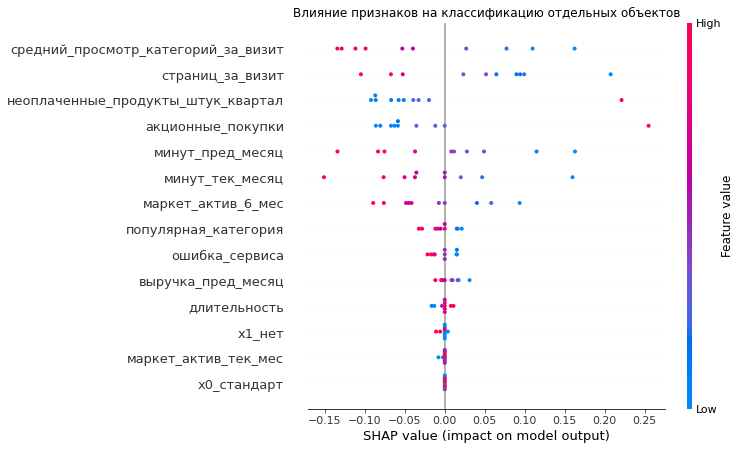

In [83]:
plt.title('Влияние признаков на классификацию отдельных объектов')
shap.plots.beeswarm(shap_values[:,:,1], max_display=16) 

In [84]:
f = lambda x: classifier.predict_proba(x)[:,1]
med = X_train_processed.median().values.reshape((1,X_train_processed.shape[1]))
explainer = shap.KernelExplainer(f, med)

In [85]:
shap_values = explainer.shap_values(X_test_processed.iloc[0:100,:])

  0%|          | 0/100 [00:00<?, ?it/s]

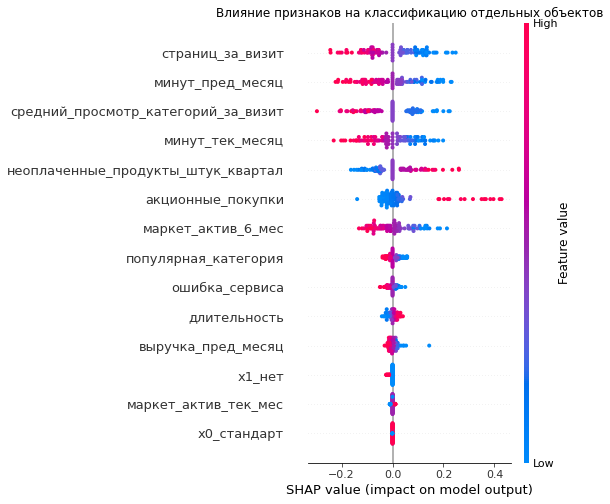

In [86]:
plt.title('Влияние признаков на классификацию отдельных объектов')
shap.summary_plot(shap_values, X_test_processed.iloc[0:100,:])

Из графика выше можно сделать следующие наблюдения о пользователях со сниженной покупательской активностью:
- пользователь просматривает мало страниц и мало категорий
- мало времени проводит за один визит на сайт
- в корзине много неоплаченных товаров 
- интересуется покупками по акциям
- получает мало рассылок, спецпредложений и других возможных маркетинговых активностей

### Вывод

Пользователь актвиность которого снижается, проводит на сайте меньше времени и меньше просматривает разных товаров. Понравившиеся товары добаывдяет в корзину, но не покупает. Предпочитает покупать по акциям. Таким образом, чтобы повысить активность таких пользователей среди бизнес-решений может быть:

- увеличить количество акций на товары
- специальные предложения на товары, которые залежались в корзине
- способы увеличения времяпрепровождения на сайте - показывать более релевантные интересам пользователя товары
- увеличить количество маркетинговых активностей.

## 8. Сегментация покупателей

Рассмотрим сегмент покупателей - с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

In [87]:
segment = all_data.query('акционные_покупки > 0.8 and покупательская_активность=="снизилась"')

In [88]:
segment.покупательская_активность.value_counts()

снизилась    132
Name: покупательская_активность, dtype: int64

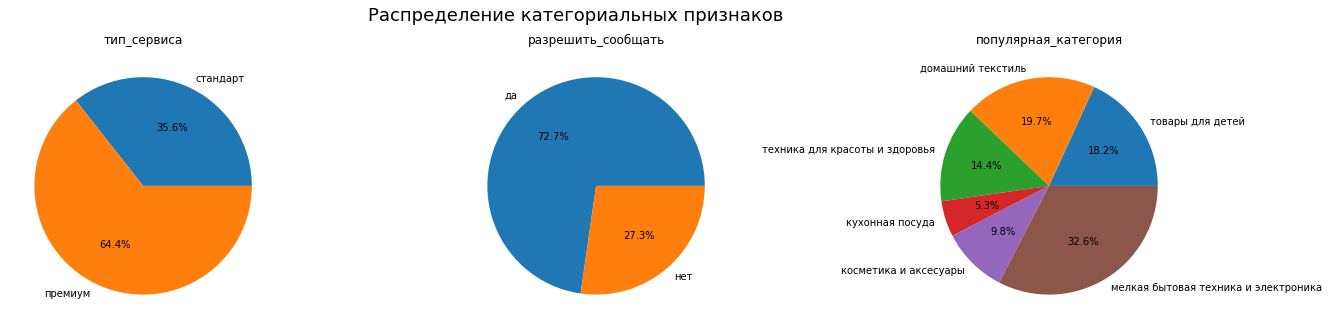

In [89]:
segment = segment.drop(['покупательская_активность','выручка_препред_месяц', 'выручка_тек_месяц'] , axis=1)
cat_cols = segment.select_dtypes(exclude='number').columns
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23, 5))
fig.suptitle('Распределение категориальных признаков' , fontsize=18,  y = 1)
pie_for_cat(segment, cat_cols)


64% клиентов сегмента пользуются премиум сервисом. Наиболее популярной категорией товара является мелкая бытовая техника и электроника.

In [90]:
segment_processed = transform_dataframe(segment, num_columns, ord_columns, clf1)

In [91]:
shap_values = explainer1(segment_processed.sample(10))

  0%|          | 0/10 [00:00<?, ?it/s]

In [92]:
shap_values.shape

(10, 14, 2)

Посмотрим важность признаков:

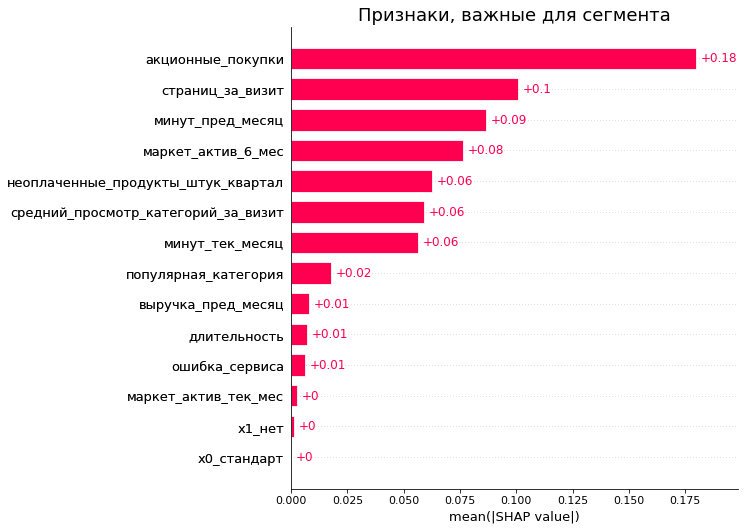

In [93]:
plt.title('Признаки, важные для сегмента', fontsize=18)
shap.plots.bar(shap_values[:,:,1], max_display=16) 

In [94]:
shap_values = explainer(segment_processed)

  0%|          | 0/132 [00:00<?, ?it/s]

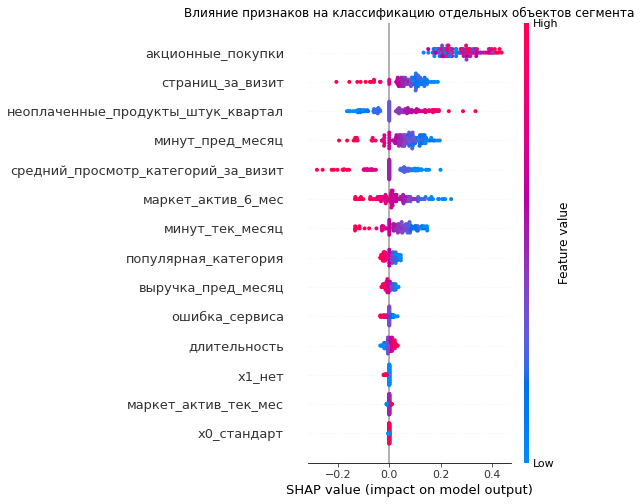

In [95]:
plt.title('Влияние признаков на классификацию отдельных объектов сегмента')
shap.summary_plot(shap_values, segment_processed)

### Вывод
Предложения по повышению покупательской активности пользователей в сегменте с максимальной долей покупок по акции и высокой вероятностью снижения:
- увеличить число акций , в том числе по наиболее популярной категории в сегменте - мелкая бытовая техника и электроника.
- увеличить время, число страниц за счет рекомендаций товаров популярной категории.
- увеличить количество маркетинговых активностей с акцентом на пользвателей премиум сервиса.
- специальные предложения на товары "залежавшиеся" в корзине

## 9. Итоговый вывод исследования

1. **Обзор данных**
 - Данные в четырех таблицах соответствуют описанию задачи. В каждой таблице 1300 уникальных клиентов. Таблица `market_file.csv` представляет собой записи о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. В таблице `market_money.csv`находятся данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. В качестве периодов представлены текущий и два прошедших месяца.  В таблице `market_time.csv`находятся данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.В таблице `money.csv` представлены данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
 - Ни в одной таблице нет пропусков. 
 - Во всех таблицах нужно соотвествующе общепринятому стилю изменить названия столбцов.
 - Необходимо убрать опечатки в отмеченных колонках.
 - Типы данных соотвествуют описываемым признакам.

2. **Предобработка данных**

В ходе предобработки:
- Переименовали столбцы во всех таблицах: представили их змеиным регистром.
- Убрали неявные дубликаты из столбца тип_сервиса таблицы market_file.
- Убрали опечатку в столбце период таблицы market_time.
- Дубликатов не обнаружено.

3. **Исследовательский анализ данных**

По группе клиентов с ненулевой покупательской активностью за три месяца провели EDA.

- Все признаки распределены реалистично. Для одного пользователя есть аномально большая сумма покупок в текущем месяце (но она может быть вполне реальной).
- В среднем, около 4 маркетинговых активностей в месяц приходится на пользователя.
- Пользователи поделелилсь на группы активных и не очень по использованию акций.
- В среднем, пользователь просматривает 5-10 страниц за визит и проводит на сайте 10-15 минут.
- Активность более 60% пользователей на сайте снизилась.
- Большинство пользуются стандартным сервисом и получают дополнительную информацию о предложениях товара.


*Для дальнейшей работы объединили таблицы `market_file.csv`, `market_money.csv`, `market_time.csv` на основании id клиентов.*

4. **Корреляционный анализ**

- - Мультиколлинеарность есть между признаками "выручка_пред_месяц" и "выручка_тек_месяц" , "выручка_препред_месяц" и "акционные_покупки" в классе сниженной активности. **Признаки "выручка_тек_месяц", "выручка_препред_месяц" не будут использованы при обучении модели.**
- Между некоторыми признаками есть линейная зависимость. Сообщение о дополнительных предложениях товара и выручка за текущий месяц и маркетинговая активность в текущем месяце самым слабым образом коррелируют с остальными признаками.

5. **Модель классификации**
- Задача моделирования состояла в классификации пользователей по активности (прежний уровень или снижение). Для подбора лучшей модели воспользовались в  метрикой ROC-AUC, т.к. наша интерес заключается в наиболее качественно разделении классов без подбора порога, кроме того, метрика адекватно работает при наличии выбросов и при дисбалансе классов в выборке.
- Для препроцессинга и обучения воспользовались пайплайнами. Для бинарных признаков воспользовались OHE, популярные категории кодировали с помощью OrdinalEncoder, масштабировали количественные данные с помощью StandardScaler.
- Базовая модель на основе дерева решений уже работала неплохо. Метрика ROC-AUC на тестовой выборке: 0.82, accuracy на тестовой выборке: 0.82, F1 на тестовой выборке: 0.78
- Для подбора лучшей модели воспользовались рандомизированным поиском с кроссвалидацией. Выбирали лучшие параметры из: 
    - вид модели: дерево решений, KNN, логистическая регрессия, SVC. При этом для каждой модели подбирали минимум один гиперпараметр.
    - метод масштабирования: StandardScaler, MinMaxScaler или без масштабирования.
- Лучшей моделью (с наибольшим значением ROC-AUC: 0.9 на кросс-валидации тренировочной выборки, 0.91 на тестовой выборке) в ходе RandomizedSearchCV выбрана модель логистической регрессии с параметром регуляризации С=8.5 и метод масштабирования количественных данных StandardScaler.

6. **Анализ важности признаков SHAP**

На основе метода SHAP были сделаны следующие выводы о важности пользовательских характеристик в определении покупательской активности клиента.
Пользователь активность которого снижается, проводит на сайте меньше времени и меньше просматривает разных товаров. Понравившиеся товары добавляет в корзину, но не покупает. Предпочитает покупать по акциям. Таким образом, чтобы повысить активность пользователей среди бизнес-решений может быть:

- увеличить количество акций на товары
- специальные предложения на товары, которые залежались в корзине
- способы увеличения времяпрепровождения на сайте - показывать более релевантные интересам пользователя товары
- увеличить количество маркетинговых активностей.

7. **Анализ сегмента покупателей с максимальной долей покупок по акции и высокой вероятностью снижения**

Для сегмента характерно преимущественно использование премиум сервиса. Наиболее популярной категорией товара в пользовательском сегменте является мелкая бытовая техника и электроника.

На основе анализа важности признаков в данной подгруппе было выявлены возможные решения для увеличения активности клиентов сегмента:
- увеличить число акций , в том числе по наиболее популярной категории в сегменте - мелкая бытовая техника и электроника.
- увеличить время, число страниц за счет рекомендаций товаров популярной категории.
- увеличить количество маркетинговых активностей с акцентом на пользвателей премиум сервиса.
- специальные предложения на товары "залежавшиеся" в корзине